# per-line transcription with LLM & OCR

In [1]:
from openai import OpenAI
from anthropic import Anthropic
import os
import re
import pandas as pd
from dotenv import load_dotenv
import requests
import base64
import subprocess
from IPython.display import display, Image
from PIL import Image as PILImage

In [2]:
import cv2
import easyocr
import matplotlib.pyplot as plt
import pytesseract
import keras_ocr

In [3]:
path = os.path.dirname(os.getcwd()) # Parent directory
image_folder = path+'/data/lines'

In [4]:
# OpenAI
load_dotenv() #get the environment 
openai_API_KEY = os.getenv("OPENAI_API_KEY")
openai_client = OpenAI(api_key=openai_API_KEY)

In [5]:
anthropic_API_KEY = os.getenv("ANTHROPIC_API_KEY")
anthropic_client = Anthropic(api_key=anthropic_API_KEY)
MODEL_NAME = "claude-3-5-sonnet-20240620"

## Read and encode the images

In [6]:
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

In [7]:
images = []
for image in os.listdir(image_folder):
    if image.endswith('.jpg'):
        images.append(image)

rows = []
for image in images:
    name = image.split('.')[0]
    name_split = name.split('_')[0]
    file_name = name_split.split('example')[1]
    line_name = name.split('_')[1]
    encoded_value = encode_image(image_folder+'/'+image)
    rows.append({'file': file_name, 'line': line_name, 'encoded': encoded_value})

images_encoded = pd.DataFrame(rows)

In [8]:
images_encoded['file'] = images_encoded['file'].astype('int')
images_encoded['line'] = images_encoded['line'].astype('int')
images_encoded = images_encoded.sort_values(by=['file', 'line']).reset_index(drop=True)
images_encoded['id'] = images_encoded['file'].astype(str) + '_' + images_encoded['line'].astype(str)
images_encoded.head(30)

,file,line,encoded,id
0,1,0,/9j/4QczRXhpZgAATU0AKgAAAAgADQEAAAMAAAABD5YAAA...,1_0
1,1,1,/9j/4QZBRXhpZgAATU0AKgAAAAgADQEAAAMAAAABD5YAAA...,1_1
2,1,2,/9j/4QX5RXhpZgAATU0AKgAAAAgADQEAAAMAAAABD5YAAA...,1_2
3,1,3,/9j/4QYvRXhpZgAATU0AKgAAAAgADQEAAAMAAAABD5YAAA...,1_3
4,1,4,/9j/4QZLRXhpZgAATU0AKgAAAAgADQEAAAMAAAABD5YAAA...,1_4
5,1,5,/9j/4QVaRXhpZgAATU0AKgAAAAgADQEAAAMAAAABD5YAAA...,1_5
6,1,6,/9j/4QVqRXhpZgAATU0AKgAAAAgADQEAAAMAAAABD5YAAA...,1_6
7,1,7,/9j/4QX5RXhpZgAATU0AKgAAAAgADQEAAAMAAAABD5YAAA...,1_7
8,1,8,/9j/4QWRRXhpZgAATU0AKgAAAAgADQEAAAMAAAABD5YAAA...,1_8
9,1,9,/9j/4QZyRXhpZgAATU0AKgAAAAgADQEAAAMAAAABD5YAAA...,1_9


# LLMs

## Zero-shot

In [9]:
prompt = """
    Recognize the text from the image:
    ```plaintext
"""


prompt_complex = """
    Context:
        It's an old Belgian document. And you're getting one row of a table from it. It's written in French language and the names of the people are domiciles are Belgian.

    Structure:
        The table is structured with the two-level headers as follows:
        [("N' d'ordre", " "),
                ("Date du dépot des déclarations", " "),
                ("Désignation des personnes décédées ou absentes.:", "Nom."),
                ("Désignation des personnes décédées ou absentes.:", "Prénoms"),
                ("Désignation des personnes décédées ou absentes.:", "Domiciles"), 
                ("Date du décès ou du judgement d'envoi en possession, en cas d'absence.", " "),
                ("Noms, Prénoms et demeures des parties déclarantes.", " "),
                ("Droits de succession en ligne collatérale et de mutation en ligne directe.", "Actif. (2)"),
                ("Droits de succession en ligne collatérale et de mutation en ligne directe.", "Passif. (2)"),
                ("Droits de succession en ligne collatérale et de mutation en ligne directe.", "Restant NET. (2)"),
                ("Droit de mutation par déces", "Valeur des immeubles. (2)"), 
                ("Numéros des déclarations", "Primitives."),
                ("Numéros des déclarations", "Supplémentaires."), 
                ("Date", "de l'expiration du délai de rectification."),
                ("Date", "de l'exigibilité des droits."),
                ("Numéros de la consignation des droits au sommier n' 28", " "),
                ("Recette des droits et amendes.", "Date"),
                ("Recette des droits et amendes.", "N^03"),
                ("Cautionnements. ", "Numéros de la consignation au sommier n'30"),
                ("Observations (les déclarations qui figurent à l'état n'413 doivent être émargées en conséquence, dans la présnete colonne.)", " ")] 

        Some image (hence, some rows) may start with "Arrêté le \d{2} \w+ \d{4}( \w+)? servais" or contain notes.

    Task:
        Recognize the text from the image. Pay attention to reading each word and number correctly. Return the text as you read it and you must read the text from the image since the image contains texts.
    ```plaintext 
"""

<>:7: SyntaxWarning: invalid escape sequence '\d'
<>:7: SyntaxWarning: invalid escape sequence '\d'
/var/folders/xy/r3gq5vtd7bx6qb966l0fhh9h0000gn/T/ipykernel_63694/818506988.py:7: SyntaxWarning: invalid escape sequence '\d'
  prompt_complex = """


In [18]:
def callOpenAI(prompt, max_tokens=800, base64_image=None):
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {openai_API_KEY}"
    } 
    model_vision = "gpt-4o"
    payload = {
        "model": model_vision, 
        "messages": [
        {
            "role": "system",
            "content": "You are a helpful assistant who can read old handwriting with a background in history, and you are going to recreate a scanned déclaration de succession from Belgium in a txt format."
            
        },
        {
            "role": "user",
            "content": [
            {
                "type": "text",
                "text": prompt
            },
            {
                "type": "image_url",
                "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image}"
                }
            }
            ]
        }
        ],
        "max_tokens": max_tokens,
        "temperature": 0
    }
    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    try:
        return response.json()["choices"][0]["message"]["content"]
    except:
        print(response.json()["error"]["message"])

In [18]:
def callAnthropic(prompt, max_tokens=5000, base64_image=None):
    response = anthropic_client.messages.create(
        model=MODEL_NAME,
        max_tokens=max_tokens,
        system = "You are a helpful assistant who can read old handwriting with a background in history, and you are going to recreate a scanned déclaration de succession from Belgium in a txt format.",
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "image", 
                        "source": {
                            "type": "base64", 
                            "media_type": "image/jpeg", 
                            "data": base64_image}},
                    {
                        "type": "text",
                        "text": prompt,
                    }
                ],
            }
        ],
        temperature=0,
    )
    return response.to_dict()["content"][0]["text"]

In [20]:
def callPostProcessing(max_tokens=800, prompt_parameter = None):
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {openai_API_KEY}"
    } 
    payload = {
        "model": "gpt-4o",
        "messages": [
        {
            "role": "user",
            "content": [
            {
                "type": "text",
                "text": f"""This is an output from you. Clean it such that we have no separators and no comment from you: {prompt_parameter}
                """
            }
            ]
        }
        ],
        "max_tokens": max_tokens,
        "temperature": 0
    }
    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    try:
        return response.json()["choices"][0]["message"]["content"]
    except:
        print(response.json()["error"]["message"])


In [14]:
# use this when OpenAI credits are exhausted
def callPostProcessing_anthropic(max_tokens=5000, prompt_parameter = None):
    response = anthropic_client.messages.create(
        model=MODEL_NAME,
        max_tokens=max_tokens,
        system = "You are a helpful assistant who can read old handwriting with a background in history, and you are going to recreate a scanned déclaration de succession from Belgium in a txt format.",
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": f"""This is an output from you. Clean it such that we have no separators and no comment from you: {prompt_parameter}
                """
                    }
                ],
            }
        ],
        temperature=0,
    )
    return response.to_dict()["content"][0]["text"]

### Zero-shot

In [19]:
import time
import json

# Load previous progress if available
try:
    with open('claude_complex_output_progress.json', 'r') as file:
        claude_complex_output = json.load(file)
except FileNotFoundError:
    claude_complex_output = {}

# Loop through each unique id
# for id in images_encoded['id'].unique():
for id in unable_ids_1:
    # Check if this ID is already processed (Skip this step if you want to re-process for unable_ids) ----------------
    # if id in claude_complex_output:
    #     print(f"Skipping {id}, already processed.")
    #     continue
    
    start_time = time.time()
    try:
        print(f'------- Start processing file {id} -------')
        
        # Call OpenAI/Anthropic and post-processing functions
        prompt_complex += "Even if it is hard to read the texts from the image, return as much as you can. You must read something. Do not return an apologetic message."
        # output = callOpenAI(prompt=prompt_complex, max_tokens=800, base64_image=images_encoded[(images_encoded['id'] == id)].encoded.values[0])
        output = callAnthropic(prompt=prompt_complex, max_tokens=800, base64_image=images_encoded[(images_encoded['id'] == id)].encoded.values[0])
        output_cleaned = callPostProcessing(prompt_parameter=output)
        
        # Save the output
        claude_complex_output[id] = output_cleaned
        
        # Save progress after each file
        with open('claude_complex_output_progress.json', 'w') as file:
            json.dump(claude_complex_output, file)
        
        print(f'------- Finished processing file {id} in {time.time() - start_time} seconds -------')

    except Exception as e:
        print(f"Error processing file {id}: {str(e)}")
        # Save the progress and exit the loop in case of an error
        with open('claude_complex_output_progress.json', 'w') as file:
            json.dump(claude_complex_output, file)
        break  # Exit the loop on error

# Once all IDs are processed, save the final result
with open('claude_complex_output_final.json', 'w') as file:
    json.dump(claude_complex_output, file)

print("Processing complete.")


------- Start processing file 6_1 -------
------- Finished processing file 6_1 in 4.5775532722473145 seconds -------
Processing complete.


### Few-shots

In [9]:
df = pd.read_csv(path+'/data/transcription_perline_text.csv')

In [10]:
example1 = images_encoded[images_encoded['id'] == '1_1'].encoded.values[0]
example2 = images_encoded[images_encoded['id'] == '1_2'].encoded.values[0]

In [11]:
images_encoded_oneshot = images_encoded[~images_encoded['id'].isin(['1_1'])]
images_encoded_twoshot = images_encoded[~images_encoded['id'].isin(['1_1', '1_2'])]

In [12]:
example1_text = df[df['id'] == '1_1'].text.values[0]
example2_text = df[df['id'] == '1_2'].text.values[0]

In [16]:
example_texts =  [example1_text, df[df['id'] ==  '1_3'].text.values[0]]

[' arrêté le vingt huit octobre 1919 servais                 ',
 '398 trente octobre Herrent Alphones gh Ophain 16 9b 1918 Herrent Maris & autres 2280 1045 1235 11 Db 1919 15 7bre 1919  7 avril 1920 303  ']

In [22]:
images_encoded_extexts = images_encoded[~images_encoded['id'].isin(['1_1', '1_3'])]

In [13]:
prompt_example =  """
    Recognize the texts from the image like the examples.
    ```plaintext
    """

In [16]:
# example1_text or exmple_texts
prompt_example_text = f"""
                        The ```plaintext block is the example transcription of the example image you saw:

                        Transcription:
                        ```plaintext
                        {example1_text}
                        ```
                        Compare what you read initially and the solution key in ```plaintext block. Recreate the content of the table in this image. Only that, no other information from you.

                        """


In [14]:
def callOpenAI_example(prompt, example1, example2=None, NExample=1, base64_image=None, max_tokens=5000):
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {openai_API_KEY}"
    } 
    model_vision = "gpt-4o"

    if NExample == 1:
        payload = {
            "model": model_vision, 
            "messages": [
            {
                "role": "system",
                "content": "You are a helpful assistant who can read old handwriting with a background in history, and you are going to recreate a scanned déclaration de succession from Belgium in a txt format."
                
            },
            {
                "role": "user",
                "content": [
                {
                    "type": "image_url",
                    "image_url": {
                    "url": f"data:image/jpeg;base64,{example1}"
                    }
                },
                {
                    "type": "text",
                    "text": example1_text
                },
                {
                    "type": "text",
                    "text": prompt
                },
                {
                    "type": "image_url",
                    "image_url": {
                    "url": f"data:image/jpeg;base64,{base64_image}"
                    }
                }
                ]
            }
            ],
            "max_tokens": max_tokens,
            "temperature": 0
        }
    if NExample == 2:
               payload = {
            "model": model_vision, 
            "messages": [
            {
                "role": "system",
                "content": "You are a helpful assistant who can read old handwriting with a background in history, and you are going to recreate a scanned déclaration de succession from Belgium in a txt format."
                
            },
            {
                "role": "user",
                "content": [
                {
                    "type": "image_url",
                    "image_url": {
                    "url": f"data:image/jpeg;base64,{example1}"
                    }
                },
                {
                    "type": "text",
                    "text": example1_text
                },
                {
                    "type": "image_url",
                    "image_url": {
                    "url": f"data:image/jpeg;base64,{example2}"
                    }
                },
                {
                    "type": "text",
                    "text": example2_text
                },
                {
                    "type": "text",
                    "text": prompt
                },
                {
                    "type": "image_url",
                    "image_url": {
                    "url": f"data:image/jpeg;base64,{base64_image}"
                    }
                }
                ]
            }
            ],
            "max_tokens": max_tokens,
            "temperature": 0
        }
    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    try:
        return response.json()["choices"][0]["message"]["content"]
    except:
        print(response.json()["error"]["message"])

In [16]:
def callAnthropic_example(prompt, example1, example2=None, NExample=1, base64_image=None, max_tokens=5000):
    if NExample == 1:
        response = anthropic_client.messages.create(
            model=MODEL_NAME,
            max_tokens=max_tokens,
            system = "You are a helpful assistant who can read old handwriting with a background in history, and you are going to recreate a scanned déclaration de succession from Belgium in a txt format.",
            messages=[
                {
                    "role": "user",
                    "content": [
                        {"type": "image", 
                            "source": {
                                "type": "base64", 
                                "media_type": "image/jpeg", 
                                "data": example1}},
                        {
                            "type": "text",
                            "text": example1_text,
                        },
                        {
                            "type": "text",
                            "text": prompt,
                        },
                        {"type": "image", 
                            "source": {
                                "type": "base64", 
                                "media_type": "image/jpeg", 
                                "data": base64_image}}
                    ],
                }
            ],
            temperature=0,
        )
        
    if NExample == 2:
        response = anthropic_client.messages.create(
            model=MODEL_NAME,
            max_tokens=max_tokens,
            system = "You are a helpful assistant who can read old handwriting with a background in history, and you are going to recreate a scanned déclaration de succession from Belgium in a txt format.",
            messages=[
                {
                    "role": "user",
                    "content": [
                        {"type": "image", 
                            "source": {
                                "type": "base64", 
                                "media_type": "image/jpeg", 
                                "data": example1}},
                        {
                            "type": "text",
                            "text": example1_text,
                        },
                        {"type": "image", 
                            "source": {
                                "type": "base64", 
                                "media_type": "image/jpeg", 
                                "data": example2}},
                        {
                            "type": "text",
                            "text": example2_text,
                        },
                        {
                            "type": "text",
                            "text": prompt,
                        },
                        {"type": "image", 
                            "source": {
                                "type": "base64", 
                                "media_type": "image/jpeg", 
                                "data": base64_image}}
                    ],
                }
            ],
            temperature=0,
        )
    return response.to_dict()["content"][0]["text"]

In [34]:
import time
import json

# Load previous progress if available
try:
    with open('claude_one_text_example_output_progress.json', 'r') as file:
        claude_one_text_example_output = json.load(file)
except FileNotFoundError:
    claude_one_text_example_output = {}

# Loop through each unique id
for id in images_encoded_oneshot['id'].unique():
# for id in unable_ids_3:
    # Check if this ID is already processed (Skip this step if you want to re-process for unable_ids) ----------------
    if id in claude_one_text_example_output:
        print(f"Skipping {id}, already processed.")
        continue
    
    start_time = time.time()
    try:
        print(f'------- Start processing file {id} -------')
        
        # Call OpenAI/Anthropic and post-processing functions
        prompt_example_text += "Even if it is hard to read the texts from the image, return as much as you can. You must read something. Do not return an apologetic message."
        # output = callOpenAI_example(prompt=prompt_example, example1=example1, example2=None, NExample=1, base64_image=images_encoded_oneshot[(images_encoded_oneshot['id'] == id)].encoded.values[0], max_tokens=800)
        output = callAnthropic(prompt=prompt_example_text, base64_image=images_encoded_oneshot[(images_encoded_oneshot['id'] == id)].encoded.values[0], max_tokens=800)
        output_cleaned = callPostProcessing_anthropic(prompt_parameter=output)
        
        # Save the output
        claude_one_text_example_output[id] = output_cleaned
        
        # Save progress after each file
        with open('claude_one_text_example_output_progress.json', 'w') as file:
            json.dump(claude_one_text_example_output, file)
        
        print(f'------- Finished processing file {id} in {time.time() - start_time} seconds -------')

    except Exception as e:
        print(f"Error processing file {id}: {str(e)}")
        # Save the progress and exit the loop in case of an error
        with open('claude_one_text_example_output_progress.json', 'w') as file:
            json.dump(claude_one_text_example_output, file)
        break  # Exit the loop on error

# Once all IDs are processed, save the final result
with open('claude_one_text_example_output_final.json', 'w') as file:
    json.dump(claude_one_text_example_output, file)

print("Processing complete.")


Skipping 1_0, already processed.
Skipping 1_2, already processed.
Skipping 1_3, already processed.
Skipping 1_4, already processed.
Skipping 1_5, already processed.
Skipping 1_6, already processed.
Skipping 1_7, already processed.
Skipping 1_8, already processed.
Skipping 1_9, already processed.
Skipping 1_10, already processed.
Skipping 1_11, already processed.
Skipping 1_12, already processed.
Skipping 1_13, already processed.
Skipping 2_0, already processed.
Skipping 2_1, already processed.
Skipping 2_2, already processed.
Skipping 2_3, already processed.
Skipping 2_4, already processed.
Skipping 2_5, already processed.
Skipping 2_6, already processed.
Skipping 2_7, already processed.
Skipping 2_8, already processed.
Skipping 2_9, already processed.
Skipping 2_10, already processed.
Skipping 2_11, already processed.
Skipping 2_12, already processed.
Skipping 2_13, already processed.
Skipping 2_14, already processed.
Skipping 3_0, already processed.
Skipping 3_1, already processed.
S

### Outputs

In [35]:
claude_one_text_example_output

{'1_0': "N° DATE DU DÉPÔT DÉSIGNATION DES PERSONNES DÉCÉDÉES OU ABSENTES DATE DU DÉCÈS DROITS DE SUCCESSION DROIT DE MUTATION NUMÉROS RECETTE OBSERVATIONS\ndes NOMS PRÉNOMS DOMICILES ou du NOMS, PRÉNOMS EN LIGNE COLLATÉRALE par décès des DATE des\nDÉCLARATIONS JUGEMENT D'ENVOI ET ET DE DÉCLARATIONS DROITS ET AMENDES\nEN POSSESSION DEMEURES DES PARTIES DÉCLARANTES MUTATION EN LIGNE DIRECTE\nACTIF PASSIF RESTANT NET",
 '1_2': 'arrêté le vingt neuf octobre 1919 servais',
 '1_3': '398 Octobre Herrent Alphonse Joseph orphelin 1892/1913 Herrent Désiré & autres 2280 1085 1195 11.95 15 f 1919 feuillet 365',
 '1_4': '398² Lefebvre Jules Brasseur Jemappes Nicolle Amélie xxxx xxxx 210\n1919',
 '1_5': 'arrêté le vingt huit octobre 1919 servais',
 '1_6': 'arrêté le vingt huit octobre 1919 servais',
 '1_7': 'Arrêté le premier novembre 1919 Toussaint Servais',
 '1_8': 'Arrêté le deux novembre 1919 Dimanche Servais',
 '1_9': '399\nDesmedt Jeanne\nNivelles\n13 mai 1919\nWaterloo\nCélib. rentière\n9110\

In [36]:
unable_ids = [id for id, content in claude_one_text_example_output.items() if "unable" in content or "I apologize" in content or "The image" in content]
print(unable_ids, len(unable_ids), sep='\n')

[]
0


### To run with the saved json

In [37]:
claude_one_text_example_output_df = pd.DataFrame(claude_one_text_example_output.items(), columns=['id', 'text'])
# gpt_complex_output_df = pd.DataFrame(gpt_complex_output.items(), columns=['id', 'content'])

In [38]:
# claude_output_df['content'] = claude_output_df['content'].replace(['\n', '\t'], ' ', regex=True)
claude_one_text_example_output_df['text'] = claude_one_text_example_output_df['text'].replace(['\n', '\t'], ' ', regex=True)
claude_one_text_example_output_df

,id,text
0,1_0,N° DATE DU DÉPÔT DÉSIGNATION DES PERSONNES DÉC...
1,1_2,arrêté le vingt neuf octobre 1919 servais
2,1_3,398 Octobre Herrent Alphonse Joseph orphelin 1...
3,1_4,398² Lefebvre Jules Brasseur Jemappes Nicolle ...
4,1_5,arrêté le vingt huit octobre 1919 servais
...,...,...
277,20_9,10 décembre 1930 Pelaians Cambi Morelle 22 avr...
278,20_10,10² 5 Dubois Alexandre épicier 5/8/1919 décédé...
279,20_11,arrêté le dix neuf février 1920 servais
280,20_12,arrêté le vingt huit octobre 1919 servais


In [39]:
# claude_output_df.to_csv(path+'/results/postprocessed/claude_perline_output.csv', index=False)
claude_one_text_example_output_df.to_csv(path+'/results/postprocessed/claude_one_text_example_perline_output.csv', index=False)

## CER/BLEU calculation

## ground truth df

In [110]:
from glob import glob

text_path = path+'/data/transcriptions'
file_list = glob(os.path.join(text_path, 'transcription_ex*.txt'))

df_list = []

for file in file_list:
    with open(file, 'r', encoding='utf-8') as f:
        content = f.read()
    lines = content.split('\n')

    df = pd.DataFrame({
        'line': range(0, len(lines)),  # Line numbers starting from 0
        'text': lines
    })
    
    name = os.path.basename(file)
    name = name.split('.')[0]
    df['file'] = name.split('ex')[1]
    df['file'] = df['file'].astype(int)
    df_list.append(df)
df = pd.concat(df_list, ignore_index=True)

In [111]:
df['text'] = df['text'].replace(['\n', '\t'], ' ', regex=True)
df = df.sort_values(by=['file', 'line']).reset_index(drop=True)
df

,line,text,file
0,0,N' d'ordre Date du dépot des déclarations Dési...,1
1,1,Nom. Prénoms Domiciles Actif. (2) Passif. (2) ...,1
2,2,arrêté le vingt huit octobre 1919 servais ...,1
3,3,arrêté le vingt neuf octobre 1919 servais ...,1
4,4,398 trente octobre Herrent Alphones gh Ophain ...,1
...,...,...,...
298,10,19 dix neuf d Pétriaux Coralie Nivelles 22 av...,20
299,11,19^2 d Dubois Alexandre Quenast 7b 1919 Dubois...,20
300,12,Arrêté le dix neuf février 1920 servais,20
301,13,Arrêté le vingt février 1920 servais,20


In [112]:
# Merge the text values of line number 0 and 1 (the two lines of the header)
for file in df['file'].unique():
    header_lines = df[(df['file'] == file) & (df['line'].isin([0, 1]))]
    df.loc[header_lines.index[0], 'text'] = header_lines.iloc[0]['text'] + " " + header_lines.iloc[1]['text']
df = df[df['line'] != 1].reset_index(drop=True)

In [113]:
df.loc[df['line'] != 0, 'line'] -= 1  # Adjust line numbers after removing the second line of the header

In [30]:
# # for file 6, two lines are used for some column.. we need to merge them
# doubled_line = df[(df['file'] == 6) & (df['line'].isin([3, 4]))]
# df.loc[doubled_line.index[0], 'text'] = doubled_line.iloc[0]['text'] + " " + doubled_line.iloc[1]['text']
# df.drop(doubled_line.index[1], inplace=True)
# df.loc[(df['file'] == 6) & (df['line'] > 4), 'line'] -= 1


In [114]:
df[df['file']==1]

,line,text,file
0,0,N' d'ordre Date du dépot des déclarations Dési...,1
1,1,arrêté le vingt huit octobre 1919 servais ...,1
2,2,arrêté le vingt neuf octobre 1919 servais ...,1
3,3,398 trente octobre Herrent Alphones gh Ophain ...,1
4,4,398^2 d Lefévre Jules Braine l'Alleud 8 Janvie...,1
5,5,arrêté le trente octobre 1919 servais ...,1
6,6,arrêté le trente un octobre 1919 servais ...,1
7,7,arrêté le premier novembre 1919 Toussaint ser...,1
8,8,arrêté le deux novembre 1919 Dimanche servais...,1
9,9,399 trois 9bre Desmedt Jeanne Nivelles 13 mai ...,1


In [115]:
df['id'] = df['file'].astype(str) + '_' + df['line'].astype(str)
df

,line,text,file,id
0,0,N' d'ordre Date du dépot des déclarations Dési...,1,1_0
1,1,arrêté le vingt huit octobre 1919 servais ...,1,1_1
2,2,arrêté le vingt neuf octobre 1919 servais ...,1,1_2
3,3,398 trente octobre Herrent Alphones gh Ophain ...,1,1_3
4,4,398^2 d Lefévre Jules Braine l'Alleud 8 Janvie...,1,1_4
...,...,...,...,...
278,9,19 dix neuf d Pétriaux Coralie Nivelles 22 av...,20,20_9
279,10,19^2 d Dubois Alexandre Quenast 7b 1919 Dubois...,20,20_10
280,11,Arrêté le dix neuf février 1920 servais,20,20_11
281,12,Arrêté le vingt février 1920 servais,20,20_12


In [116]:
for file in df['file'].unique():
    last_line = df[df['file'] == file]['line'].max()
    print(f"File: {file}, Last Line: {last_line}")

File: 1, Last Line: 13
File: 2, Last Line: 14
File: 3, Last Line: 13
File: 4, Last Line: 13
File: 5, Last Line: 14
File: 6, Last Line: 14
File: 7, Last Line: 13
File: 8, Last Line: 13
File: 9, Last Line: 13
File: 10, Last Line: 13
File: 11, Last Line: 13
File: 12, Last Line: 13
File: 13, Last Line: 13
File: 14, Last Line: 13
File: 15, Last Line: 13
File: 16, Last Line: 13
File: 17, Last Line: 13
File: 18, Last Line: 13
File: 19, Last Line: 13
File: 20, Last Line: 13


In [117]:
df.to_csv(path+'/data/transcription_perline_text.csv', index=False)

In [88]:
print(df['id'].nunique(), claude_output_df['id'].nunique())

283 283


## Calculate

In [40]:
df = pd.read_csv(path+'/data/transcription_perline_text.csv')

In [41]:
from evaluate import load

cer_metric =load("cer")
bleu_metric = load("bleu")  

In [42]:
df_one_example = df[~df['id'].isin(['1_1'])] #two eamples: '1_1', '1_2' or '1_1', '1_3'

In [43]:
bleu_gpt = {}
cer_gpt = {}

for id in df_one_example['id'].unique():
    # Extract the text as a single string, not as an array
    pred_text = claude_one_text_example_output_df[claude_one_text_example_output_df['id'] == id]['text'].values[0]
    ref_text = df_one_example[df_one_example['id'] == id]['text'].values[0]

    # Ensure the predictions and references are passed as a list of strings
    if pred_text and ref_text:  # Check if both texts are not empty (which happens for some OCR outputs)
        bleu_gpt[id] = bleu_metric.compute(predictions=[pred_text], references=[ref_text])
    else:
        bleu_gpt[id] = {'bleu': 0.0}  # Assign a default value if texts are empty
    cer_gpt[id] = cer_metric.compute(predictions=[pred_text], references=[ref_text])


In [44]:
bleu_gpt = pd.DataFrame(bleu_gpt).T

In [45]:
print(bleu_gpt['bleu'].mean(), bleu_gpt['bleu'].var())

0.1590146833079509 0.09004643327736263


In [46]:
bleu_gpt['id'] = bleu_gpt.index
bleu_gpt

,bleu,precisions,brevity_penalty,length_ratio,translation_length,reference_length,id
1_0,0.0,"[0.14285714285714285, 0.016129032258064516, 0....",0.243485,0.414474,63,152,1_0
1_2,1.0,"[1.0, 1.0, 1.0, 1.0]",1.0,1.0,7,7,1_2
1_3,0.0,"[0.36363636363636365, 0.09523809523809523, 0.0...",0.796703,0.814815,22,27,1_3
1_4,0.0,"[0.18181818181818182, 0.0, 0.0, 0.0]",0.529213,0.611111,11,18,1_4
1_5,0.0,"[0.7142857142857143, 0.5, 0.2, 0.0]",1.0,1.166667,7,6,1_5
...,...,...,...,...,...,...,...
20_9,0.0,"[0.5454545454545454, 0.2857142857142857, 0.1, ...",0.955563,0.956522,22,23,20_9
20_10,0.0,"[0.3684210526315789, 0.16666666666666666, 0.0,...",0.85394,0.863636,19,22,20_10
20_11,0.809107,"[0.8571428571428571, 0.8333333333333334, 0.8, ...",1.0,1.0,7,7,20_11
20_12,0.0,"[0.42857142857142855, 0.16666666666666666, 0.0...",1.0,1.166667,7,6,20_12


In [47]:
bleu_gpt['file'] = bleu_gpt['id'].str.split('_').str[0].astype(int)
bleu_gpt.groupby('file')['bleu'].agg(['mean', 'var'])

,mean,var
file,,
1,0.227986,0.115795
2,0.190718,0.11895
3,0.205776,0.111809
4,0.133389,0.061471
5,0.050656,0.03849
6,0.079325,0.035794
7,0.188521,0.130384
8,0.0576,0.009858
9,0.276779,0.160047


In [48]:
bleu_gpt.to_csv(path+'/results/scores_comparisons/eval/bleu_claude_one_text_example_perline.csv')

In [49]:
cer_gpt = pd.DataFrame(cer_gpt.items(), columns=['id', 'cer'])

In [50]:
print(cer_gpt['cer'].mean(), cer_gpt['cer'].var())

0.3560293278104556 0.07418452178113498


In [51]:
cer_gpt.to_csv(path+'/results/scores_comparisons/eval/cer_claude_one_text_example_perline.csv')

In [52]:
cer_gpt['file'] = cer_gpt['id'].str.split('_').str[0].astype(int)
cer_gpt.groupby('file')['cer'].agg(['mean', 'var'])

,mean,var
file,,
1,0.323091,0.071592
2,0.340379,0.055958
3,0.340754,0.051930
4,0.295472,0.046730
5,0.422537,0.056606
6,0.387325,0.045909
7,0.301438,0.051626
8,0.360079,0.028633
9,0.237097,0.069011


# OCR

## EasyOCR

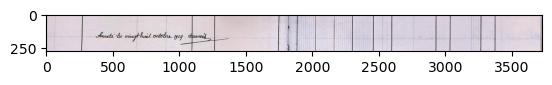

In [148]:
test_image = cv2.imread(test_path)
plt.imshow(test_image)

In [128]:
def easyOCR(image_path):
    reader = easyocr.Reader(['fr'])
    img = cv2.imread(image_path)
    results = reader.readtext(img)
    output = []
    for res in results:
        det, conf = res[1], res[2]
        output.append((det, round(conf, 2))) 
    text = ' '.join([i[0] for i in output])
    return text

In [129]:
easyOCR_output = {}
for image in os.listdir(image_folder):
    if image.endswith('.jpg'):
        image_path = image_folder + '/' + image
        text = easyOCR(image_path)
        name = image.split('.')[0]
        name = name.split('example')[1]
        easyOCR_output[name] = text

In [43]:
# easyOCR_output_df = pd.read_csv(path+'/results/postprocessed/easyOCR_perline_output.csv')
easyOCR_output_df

,file,text,file_name,line_name,id
0,1_00,DÉSIGNATION DES PERSONNES DÉCÉDÉES OU AlSENTES...,1,0,1_0
1,1_01,~Bcrta` 8 oetolz 1919 d4earuey vicytAul,1,1,1_1
2,1_02,Jbsucala & veyhmeuf ouoba tg19 [eevœy,1,2,1_2
3,1_03,891 ta HBevcenk ~Bepkonssjk oj hain Hgoucoal Y...,1,3,1_3
4,1_04,"TulL Bouuù Q ""Janer ~aobà Bhuile RRXR 26 aplul...",1,4,1_4
...,...,...,...,...,...
278,20_09,J9 ùcà nuf> Sebiaw bo2nbi YÉvepQu X anel Bebel...,20,9,20_9
279,20_10,4 49 0 : @ubovs ssexanbz Yuemaut ubuùd *ean [l...,20,10,20_10
280,20_11,Jvuté & oi = neuf fasles19:0 Huclai,20,11,20_11
281,20_12,Jarsalé - vms] Hinsenq %0 djeceia |,20,12,20_12


In [136]:
easyOCR_output_df = pd.DataFrame(easyOCR_output.items(), columns=['file', 'text'])
easyOCR_output_df[['file_name', 'line_name']] = easyOCR_output_df['file'].str.split('_', expand=True)
easyOCR_output_df[['file_name', 'line_name']] = easyOCR_output_df[['file_name', 'line_name']].astype(int)
easyOCR_output_df = easyOCR_output_df.sort_values(by=['file_name', 'line_name']).reset_index(drop=True)
easyOCR_output_df['text'] = easyOCR_output_df['text'].replace(['\n', '\t'], ' ', regex=True)
easyOCR_output_df['id'] = easyOCR_output_df['file_name'].astype(str) + '_' + easyOCR_output_df['line_name'].astype(str)
easyOCR_output_df

,file,text
0,10_00,DATE I IÉcis DROITS DF SUCCESSION DROIT NUMÉRO...
1,10_01,soceti & tù déeemebza. 919 Yuepiy
2,10_02,5 1439 DaLenlize Yiceppu #9lugu | Benuue YLama...
3,10_03,Jaxat' € deeemlaac919 Fuupùa quebu
4,10_04,[4ho ceæy _ (ekalque Pnag;nl Yjuuy Wv&ezlbz (...
...,...,...
278,9_09,69*2.4 Scinllane Pots+a Gxz9& SasBBoe Gpmzeyen...
279,9_10,"kag' 0: Sainllane Bwun' à 26r' 1sr ""9"
280,9_11,Joaak + fnmauu dceehu 1919 Yeoeok
281,9_12,[4Jg %eu 3- CBaslice fe At Z8ma 2e+eygu | Jwti...


In [44]:
easyOCR_output_df.to_csv(path+'/results/postprocessed/easyOCR_perline_output.csv', index=False)

### Pytesseract

In [10]:
def pytesseractOCR(image_path):
    try:
        image = PILImage.open(image_path)
        text = pytesseract.image_to_string(image)
        return text
    except:
        print("[ERROR] pytesseractOCR failed! (should be installed)")
        return ""

In [11]:
pytesseractOCR_output = {}
for image in os.listdir(image_folder):
    if image.endswith('.jpg'):
        image_path = image_folder + '/' + image
        text = pytesseractOCR(image_path)
        name = image.split('.')[0]
        name = name.split('example')[1]
        pytesseractOCR_output[name] = text

In [55]:
pytesseractOCR_output_df = pd.DataFrame(pytesseractOCR_output.items(), columns=['file', 'text'])
pytesseractOCR_output_df[['file_name', 'line_name']] = pytesseractOCR_output_df['file'].str.split('_', expand=True)
pytesseractOCR_output_df[['file_name', 'line_name']] = pytesseractOCR_output_df[['file_name', 'line_name']].astype(int)
pytesseractOCR_output_df = pytesseractOCR_output_df.sort_values(by=['file_name', 'line_name']).reset_index(drop=True)
pytesseractOCR_output_df['text'] = pytesseractOCR_output_df['text'].replace(['\n', '\t'], ' ', regex=True)
pytesseractOCR_output_df['id'] = pytesseractOCR_output_df['file_name'].astype(str) + '_' + pytesseractOCR_output_df['line_name'].astype(str)
pytesseractOCR_output_df

,file,text,file_name,line_name,id
0,1_00,| = | DATE DU DEPOT des DECLARATIONS. DESI...,1,0,1_0
1,1_01,ft alt alta,1,1,1_1
2,1_02,,1,2,1_2
3,1_03,a cnte |Abevcenk a dette Son <a 1040’ i ee ...,1,3,1_3
4,1_04,L 3 be oi 7 Nf »- p,1,4,1_4
...,...,...,...,...,...
278,20_09,149 28 auf Si elaiawx Ve | | Wvebly eu ty ...,20,9,20_9
279,20_10,; a : oe ssa song o Sannin nomena ie 3 (0....,20,10,20_10
280,20_11,| aul,20,11,20_11
281,20_12,Caen torah Winéorg ty dieser’ es oe aaa. pa...,20,12,20_12


In [56]:
pytesseractOCR_output_df.to_csv(path+'/results/postprocessed/pytesseractOCR_perline_output.csv', index=False)

### Keras

Not good for non-english?

In [139]:
def kerasOCR(image_path):
    pipeline = keras_ocr.pipeline.Pipeline()
    image = keras_ocr.tools.read(image_path)
    prediction_groups = pipeline.recognize([image])
    words = []
    for line in prediction_groups[0]:
        for word in line:
            try:
                if isinstance(word[0], str):
                    words.append(word[0])
            except IndexError:
                continue
    text = ' '.join(words)
    return text

In [140]:
kerasOCR_output = {}
for image in os.listdir(image_folder):
    if image.endswith('.jpg'):
        image_path = image_folder + '/' + image
        text = kerasOCR(image_path)
        name = image.split('.')[0]
        name = name.split('example')[1]
        kerasOCR_output[name] = text

Looking for /Users/serenekim/.keras-ocr/craft_mlt_25k.h5


ValueError: Unrecognized keyword arguments passed to Dense: {'weights': [array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32), array([1., 0., 0., 0., 1., 0.], dtype=float32)]}

In [173]:
test_keras = kerasOCR(image_path=test_path)
print(test_keras)

Looking for /Users/serenekim/.keras-ocr/craft_mlt_25k.h5
Instructions for updating:
Use `tf.image.resize(...method=ResizeMethod.BILINEAR...)` instead.
Looking for /Users/serenekim/.keras-ocr/crnn_kurapan.h5
1/1 [==============================] - 1s 751ms/step
d r p o a g


## TrOCR

In [26]:
from transformers import TrOCRProcessor
from transformers import VisionEncoderDecoderModel
import torch

def trOCR(image_path):
    processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
    model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

    image = PILImage.open(image_path)

    pixel_values = processor(image, return_tensors="pt").pixel_values
    
    # Set device (GPU or CPU)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)  # Move model to the device
    pixel_values = pixel_values.to(device)  # Move image tensor to the same device
    
    try:
        generated_ids = model.generate(pixel_values, max_length=400)  # Limit max length
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        return generated_text
    except IndexError as e:
        print(f"IndexError: {e}")
        return "Error: Index out of range during generation."

In [27]:
trOCR_output = {}
for image in os.listdir(image_folder):
    if image.endswith('.jpg'):
        image_path = image_folder + '/' + image
        text = trOCR(image_path)
        name = image.split('.')[0]
        name = name.split('example')[1]
        trOCR_output[name] = text

/Users/serenekim/.pyenv/versions/3.12.0/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a d

In [31]:
trOCR_output_df = pd.DataFrame(trOCR_output.items(), columns=['file', 'text'])
trOCR_output_df[['file_name', 'line_name']] = trOCR_output_df['file'].str.split('_', expand=True)
trOCR_output_df[['file_name', 'line_name']] = trOCR_output_df[['file_name', 'line_name']].astype(int)
trOCR_output_df = trOCR_output_df.sort_values(by=['file_name', 'line_name']).reset_index(drop=True)
trOCR_output_df['text'] = trOCR_output_df['text'].replace(['\n', '\t'], ' ', regex=True)
trOCR_output_df['id'] = trOCR_output_df['file_name'].astype(str) + '_' + trOCR_output_df['line_name'].astype(str)
trOCR_output_df

,file,text,file_name,line_name,id
0,1_00,treat of the first time of the French Parliame...,1,0,1_0
1,1_01,# almost be weighted rather any standard for t...,1,1,1_1
2,1_02,# almost the original module you formerly ... ...,1,2,1_2
3,1_03,"THE GREAT BRONDSOME "" AIRMARK GABIT PARADE HAN...",1,3,1_3
4,1_04,After Congress plan himself tough back down to...,1,4,1_4
...,...,...,...,...,...
278,20_09,Manager Atkinson had made many awareness of th...,20,9,20_9
279,20_10,After the Democratic gubernatorial judge took ...,20,10,20_10
280,20_11,the best time of fourteen songs with the first...,20,11,20_11
281,20_12,""" To absorb confidence being a total of 1 000 ...",20,12,20_12


In [32]:
trOCR_output_df.to_csv(path+'/results/postprocessed/trOCR_perline_output.csv', index=False)